## 1. Introduction

This notebook shows how to connect Jupyter notebooks to a Spark Cluster, read a local CSV and store it to Hadoop as partitioned parquet files. Is also shows how to ustilise MlLIB to train ML model by Spark.

The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed.

## 2. Connection to Spark Cluster

To connect to the Spark cluster, create a SparkSession object with the following params:

+ **appName:** application name displayed at the [Spark Master Web UI](http://localhost:8080/);
+ **master:** Spark Master URL, same used by Spark Workers;
+ **spark.executor.memory:** must be less than or equals to docker compose SPARK_WORKER_MEMORY config.

## 2.1. Spark Session

SparkSession: This is the entry point for reading data and working with Spark. It's used to create DataFrames and perform various operations on distributed data.

builder: This is a builder pattern used to set various configurations for Spark.

appName("pyspark-bank"): This sets the name of the Spark application to "pyspark-bank".

master("spark://spark-master:7077"): This specifies the URL of the Spark master node. It tells Spark where to distribute the tasks.

config("spark.executor.memory", "50g"): This sets the amount of memory allocated to each Spark executor. In this case, it's set to 50 gigabytes.

getOrCreate(): This either retrieves an existing SparkSession or creates a new one if it doesn't exist.

In summary, this code initializes a SparkSession for a PySpark application named "pyspark-bank", connects it to a Spark master node with a specified URL, and sets the executor memory to 50 gigabytes

logger: Creates a logger instance specifically for the "py4j" module. Py4J is a library that enables Python programs running in a Python interpreter to dynamically access Java objects in a Java virtual machine.

logger.setLevel(logging.ERROR): Sets the logging level for the "py4j" logger to ERROR. This means that only log messages with severity level ERROR and higher will be displayed

sc.setLogLevel('ERROR'): Sets the log level for the SparkContext (sc) to ERROR. This controls the logging level for Spark-related messages, and in this case, it restricts it to display only ERROR messages

In [38]:
import numpy as np
import pyspark
from pyspark.sql import SparkSession
import logging

spark = SparkSession.\
        builder.\
        appName("pyspark-bank").\
        master("spark://spark-master:7077").\
        config("spark.executor.memory", "50g").\
        getOrCreate()
        
# Get the SparkContext
sc = spark.sparkContext

logger = logging.getLogger("py4j")
logger.setLevel(logging.ERROR)
logging.basicConfig(level=logging.ERROR)
sc.setLogLevel('ERROR')

## 3. Data Preparation
We will now load data from a local CSV and store it to Hadoop partitioned by column.
Afterward you can access Hadoop UI to explore the saved parquet files.
Access Hadoop UI on 'http://bigdata:9870' (Utilities -> Browse the files system )

In [39]:
import pandas as pd
import numpy as np
from pyspark.sql.types import *
from pyspark.sql import functions as F
import os
import time

### 3.1. Load

In [40]:
bank_df = pd.read_csv('Spark/Spark/Data/bankadditionalfull.csv', sep=';')
bank_df.head()


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [41]:
num_rows = bank_df.shape[0]
print("Number of rows:", num_rows)

Number of rows: 41188


In [42]:
#Create PySpark DataFrame from Pandas
bank_spark_df = spark.createDataFrame(bank_df)

/usr/local/spark-3.5.0-bin-hadoop3/python/pyspark/sql/pandas/conversion.py:485: FutureWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if should_localize and is_datetime64tz_dtype(s.dtype) and s.dt.tz is not None:


### 3.2. Set number of partitions

In [43]:
number_of_partitions = bank_spark_df.rdd.getNumPartitions()
print("Number of partitions:", number_of_partitions)

Number of partitions: 9


This code is related to Apache Spark and is likely used for optimizing the performance of Spark DataFrames.
Repartitioning can be useful for optimizing parallelism and improving the performance of certain operations.
cache method is used to persist the DataFrame in memory. Caching is a technique to store the DataFrame in memory, which can speed up iterative algorithms or repeated operations on the same DataFrame by avoiding recomputation.
unpersist method is used to remove the DataFrame from the cache. It releases the memory used for caching. It is often used when the cached DataFrame is no longer needed to free up resources.

In [100]:
bank_spark_df = bank_spark_df.repartition(20)
bank_spark_df.cache()
bank_spark_df.unpersist();

In [79]:
number_of_partitions = bank_spark_df.rdd.getNumPartitions()
print("Number of partitions:", number_of_partitions)

Number of partitions: 15


### 3.3. Remove dots in the column names

In [46]:
bank_spark_df = bank_spark_df.select([F.col("`" + col + "`").alias(col.replace('.', '_')) 
                          for col in bank_spark_df.columns])
print("Bank Dataframe created with schema : ")
bank_spark_df.printSchema()

Bank Dataframe created with schema : 
root
 |-- age: long (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- duration: long (nullable = true)
 |-- campaign: long (nullable = true)
 |-- pdays: long (nullable = true)
 |-- previous: long (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- emp_var_rate: double (nullable = true)
 |-- cons_price_idx: double (nullable = true)
 |-- cons_conf_idx: double (nullable = true)
 |-- euribor3m: double (nullable = true)
 |-- nr_employed: double (nullable = true)
 |-- y: string (nullable = true)



### 3.4. Check for missing values
Check for missing values and handle them appropriately (e.g. fill missing values with mean, median, or mode).

In [47]:
bank_spark_df = bank_spark_df.na.replace("unknown", None)
bank_spark_df = bank_spark_df.dropna()

### 3.5. One Hot Encoding Categorical data type columns

In [48]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder

categorical_columns = [bank_spark_df.columns[i] for i in list(range(1, 10)) + [14]]

indexer_output_names = [name + "__indexed" for name in categorical_columns]
encoder_output_names = [name + "__vec" for name in categorical_columns]

indexer = StringIndexer(inputCols=categorical_columns, outputCols=indexer_output_names)
onehoter = OneHotEncoder(inputCols=indexer_output_names, outputCols=encoder_output_names)

indexed_df = indexer.fit(bank_spark_df).transform(bank_spark_df)
one_hoted_df = onehoter.fit(indexed_df).transform(indexed_df)

label_indexer = StringIndexer(inputCol='y', outputCol='label')
one_hoted_df = label_indexer.fit(one_hoted_df).transform(one_hoted_df)

one_hoted_df = one_hoted_df.select([F.col(col) for col in one_hoted_df.columns 
                                          if "__vec" in col or col not in categorical_columns and "__indexed" not in col])
processed_spark_df = one_hoted_df.select([F.col(col) for col in one_hoted_df.columns if col != "y"])

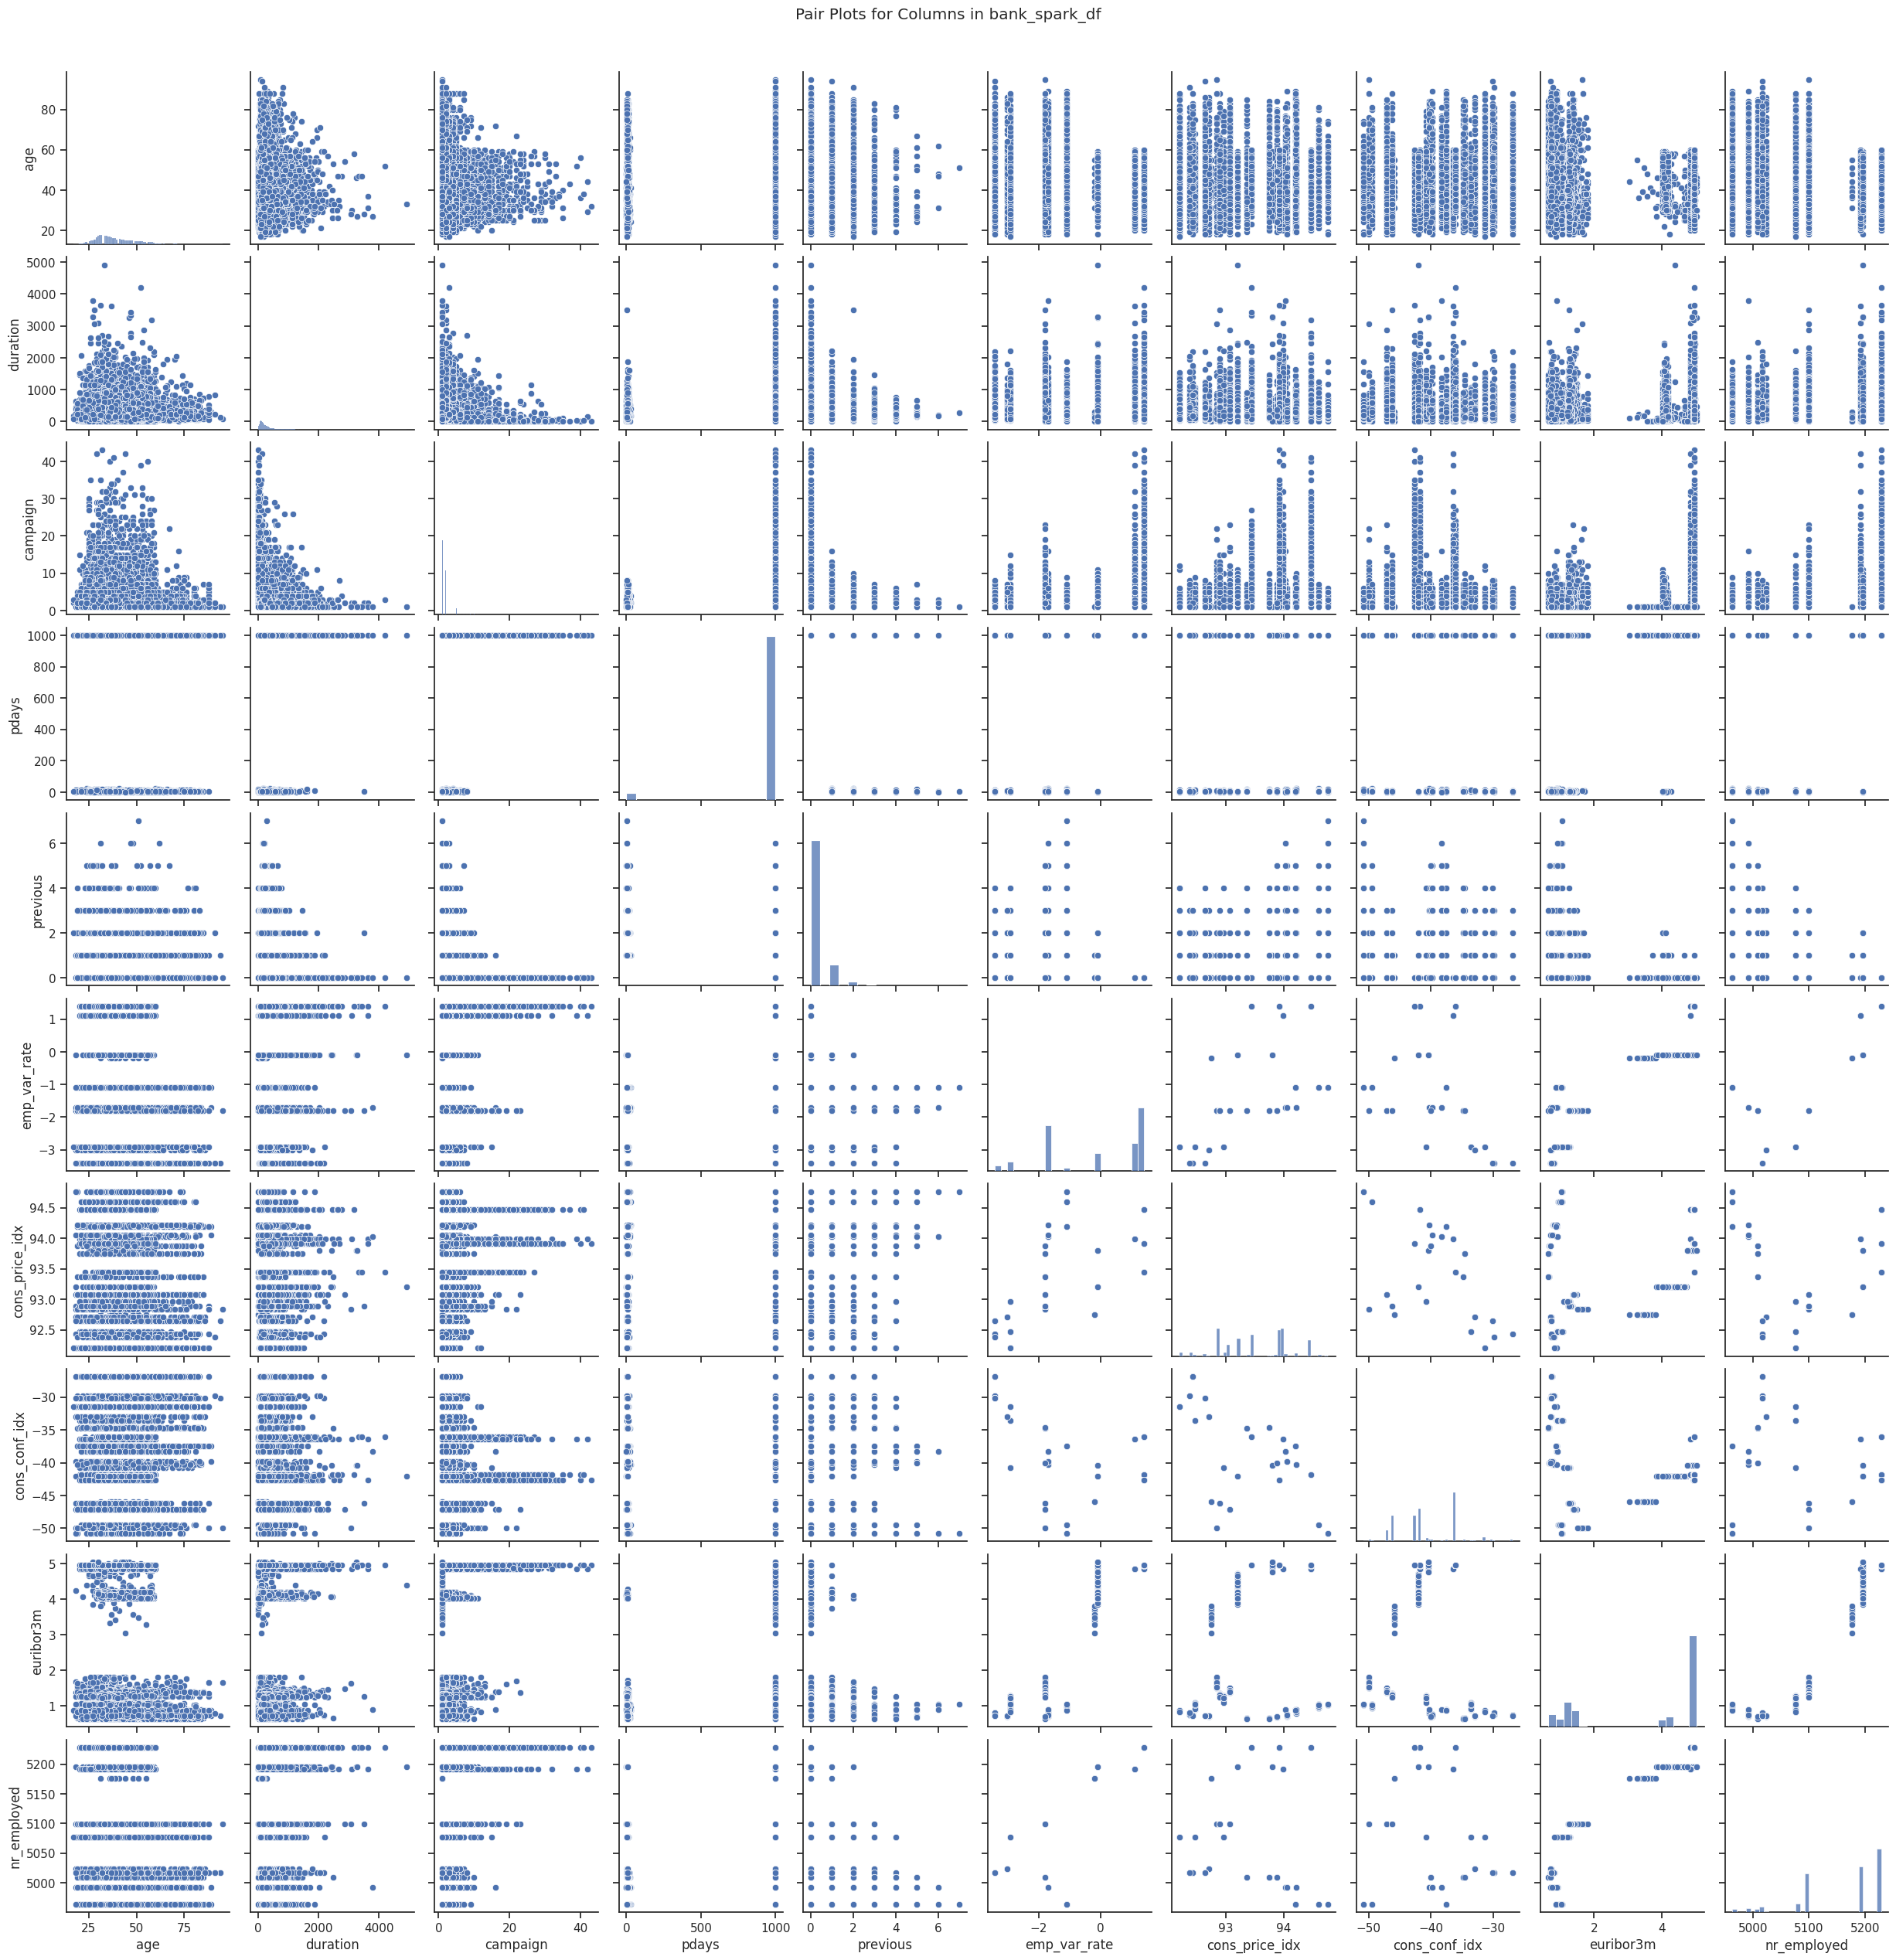

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession


# Convert Spark DataFrame to Pandas for visualization
bank_pd_df = bank_spark_df.select(bank_spark_df.columns).toPandas()

# Create pair plots using Seaborn
sns.set(style="ticks")
sns.pairplot(bank_pd_df)
plt.suptitle('Pair Plots for Columns in bank_spark_df', y=1.02)
plt.show()


### 3.6. Train & Test split

In [80]:
from pyspark.ml.feature import VectorAssembler

input_cols = processed_spark_df.columns

seed = 42
data_train, data_test = processed_spark_df.randomSplit([0.7, 0.3], seed=seed)
# Use the VectorAssembler to combine the feature columns into a single vector column
assembler = VectorAssembler(inputCols=input_cols, outputCol='features')

# Use the assembler to transform the dataset
data_train = assembler.transform(data_train)
data_test = assembler.transform(data_test)

## 4. Model selection
Choose an appropriate classification model  based on the size and characteristics of the dataset and the problem we are trying to solve.


### 4.1. Logistic Regression

In [81]:
from pyspark.ml.classification import LogisticRegression

In [82]:
# Create a logistic regression object
logr = LogisticRegression(featuresCol='features', labelCol='label')

### 4.2. Decision Tree Classifier

In [83]:
from pyspark.ml.classification import DecisionTreeClassifier

In [84]:
# Train a decision tree classifier on the training data
dt = DecisionTreeClassifier(featuresCol='features', labelCol='label')

### 4.3. Random Forest Classifier

In [85]:
from pyspark.ml.classification import RandomForestClassifier

In [86]:
# Create the Random Forest Classifier
rf = RandomForestClassifier(featuresCol='features', labelCol='label')

### 4.4. SVM Classifier

In [87]:
from pyspark.ml.classification import LinearSVC


In [88]:
svm = LinearSVC(featuresCol='features', labelCol='label')

### 4.5. Gradient-Boosted Trees (GBT) Classifier:

Gradient-Boosted Trees (GBT) is an ensemble learning algorithm used for both classification and regression tasks. It is a type of decision tree ensemble method that builds a series of weak learners (typically decision trees) in a sequential manner. Each new tree corrects the errors made by the combination of all previously built trees. GBT belongs to the family of boosting algorithms, where weak learners are combined to form a strong learner.

In [89]:
from pyspark.ml.classification import GBTClassifier

In [90]:
gbt = GBTClassifier(featuresCol='features', labelCol='label')


## 5. Model Training
Train the model using the training data.

In [91]:
# Fit the models on the training data
lr_model = logr.fit(data_train)


In [92]:
dt_model = dt.fit(data_train)


In [93]:
rf_model = rf.fit(data_train)

In [94]:
svm_model = svm.fit(data_train)

In [95]:
gbt_model = gbt.fit(data_train)

## 6. Model Evaluation
Evaluate the performance of the model on the testing data using appropriate metrics such as accuracy, precision, recall, F1-score, confusion matrix, etc.

### 6.1. Use the model to predict the labels for the test data

In [96]:
lr_predictions = lr_model.transform(data_test)
dt_predictions = dt_model.transform(data_test)
rf_predictions = rf_model.transform(data_test)
svm_predictions = svm_model.transform(data_test)
gbt_predictions = gbt_model.transform(data_test)

### 6.2. Evaluate the predictions

In [97]:
def prec_recall(predictions):
    TN = predictions.filter('prediction = 0 AND label = prediction').count()
    TP = predictions.filter('prediction = 1 AND label = prediction').count()
    FN = predictions.filter('prediction = 0 AND label = 1').count()
    FP = predictions.filter('prediction = 1 AND label = 0').count()
    
    # Calculate precision and recall
    try:
        precision = TP / (TP + FP)
    except ZeroDivisionError:
        precision = 0
    try:
        recall = TP / (TP + FN)
    except ZeroDivisionError:
        recall = 0

    return precision, recall


lr_prec_recall = prec_recall(lr_predictions)
dt_prec_recall = prec_recall(dt_predictions)
rf_prec_recall = prec_recall(rf_predictions)
svm_prec_recall = prec_recall(svm_predictions)
gbt_prec_recall = prec_recall(gbt_predictions)

In [98]:
print('Linear Regression:')
print('precision = {:.2f}\nrecall   = {:.2f}'.format(*lr_prec_recall))
print('Decision tree classifier:')
print('precision = {:.2f}\nrecall   = {:.2f}'.format(*dt_prec_recall))
print('Random Forest classifier:')
print('precision = {:.2f}\nrecall   = {:.2f}'.format(*rf_prec_recall))
print('SVM classifier:')
print('precision = {:.2f}\nrecall   = {:.2f}'.format(*svm_prec_recall))
print('GBT classifier:')
print('precision = {:.2f}\nrecall   = {:.2f}'.format(*gbt_prec_recall))

Linear Regression:
precision = 1.00
recall   = 1.00
Decision tree classifier:
precision = 1.00
recall   = 1.00
Random Forest classifier:
precision = 1.00
recall   = 0.66
SVM classifier:
precision = 1.00
recall   = 1.00
GBT classifier:
precision = 1.00
recall   = 1.00


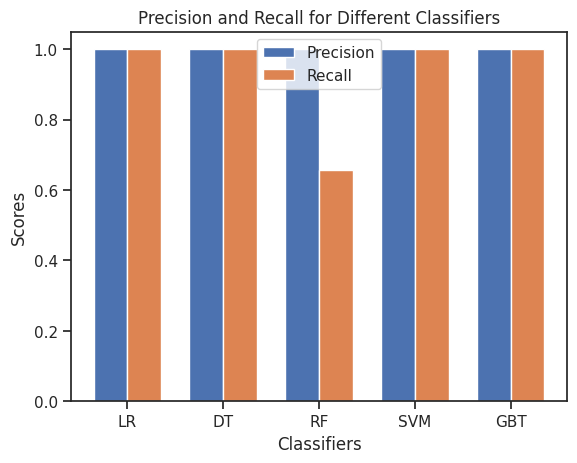

In [99]:
import matplotlib.pyplot as plt

# Assuming you have the precision and recall values stored in variables
classifiers = ['LR', 'DT', 'RF', 'SVM','GBT']
precisions = [lr_prec_recall[0], dt_prec_recall[0], rf_prec_recall[0], svm_prec_recall[0],gbt_prec_recall[0]]
recalls = [lr_prec_recall[1], dt_prec_recall[1], rf_prec_recall[1], svm_prec_recall[1],gbt_prec_recall[1]]

# Plotting precision and recall for each classifier
fig, ax = plt.subplots()
bar_width = 0.35
index = range(len(classifiers))

bar1 = ax.bar(index, precisions, bar_width, label='Precision')
bar2 = ax.bar([i + bar_width for i in index], recalls, bar_width, label='Recall')

ax.set_xlabel('Classifiers')
ax.set_ylabel('Scores')
ax.set_title('Precision and Recall for Different Classifiers')
ax.set_xticks([i + bar_width/2 for i in index])
ax.set_xticklabels(classifiers)
ax.legend()

plt.show()
